In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

from pykalman import KalmanFilter

from scipy.signal import spectrogram

In [ ]:
H5_PATH = None
FPS = 200.0  # frames per second (time step dt = 1/FPS). Update if your video differs.
DT = 1.0 / FPS

In [ ]:
assert os.path.exists(H5_PATH), f"File not found: {H5_PATH}"

with h5py.File(H5_PATH, "r") as f:
    if H5_PATH is None:
      raise ValueError(
        "H5_PATH is not set. Please provide the path to a SLEAP-exported .h5 file."
      )
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("Datasets:", dset_names)
print("locations shape:", locations.shape, " (frames, nodes, coords(xy), instances)")
print("nodes:", node_names)
frame_count, node_count, _, instance_count = locations.shape

Datasets: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
locations shape: (60725, 7, 2, 1)  (frames, nodes, coords(xy), instances)
nodes: ['left_snout_tip', 'right_snout_tip', 'top_snout_tip', 'bottom_snout_tip', 'center_snout_tip', 'jaw_tip', 'tongue_tip']


In [ ]:
TARGET_NODES = [
    "left_snout_tip", "right_snout_tip", "top_snout_tip", "bottom_snout_tip",
    "center_snout_tip", "jaw_tip", "tongue_tip"
]

def node_index_map(node_names):
    return {name: i for i, name in enumerate(node_names)}

name_to_idx = node_index_map(node_names)

nodes = {}
missing = []
for n in TARGET_NODES:
    if n in name_to_idx:
        nodes[n] = locations[:, name_to_idx[n], :, :]  # (frames, 2, instances)
    else:
        missing.append(n)

print("Loaded nodes:", list(nodes.keys()))
if missing:
    print("Missing nodes (names not found in H5):", missing)
    print("Tip: print(node_names) above and update TARGET_NODES to match your file.")

Loaded nodes: ['left_snout_tip', 'right_snout_tip', 'top_snout_tip', 'bottom_snout_tip', 'center_snout_tip', 'jaw_tip', 'tongue_tip']


In [ ]:
def fill_missing(Y, fill_value=np.nan, kind="linear"):
    """Fill missing values along axis=0 using interpolation.

    Parameters
    ----------
    Y : array, shape (T,)
    fill_value : value treated as missing (default: NaN)
    kind : interpolation kind for scipy.interpolate.interp1d

    Returns
    -------
    Y_filled : array, shape (T,)
    """
    Y = np.asarray(Y, dtype=float)
    if np.isnan(fill_value):
        mask = np.isnan(Y)
    else:
        mask = (Y == fill_value)

    if mask.all():
        return Y
    x = np.arange(len(Y))
    xp = x[~mask]
    fp = Y[~mask]
    f = interp1d(xp, fp, kind=kind, fill_value="extrapolate", bounds_error=False)
    Y_filled = Y.copy()
    Y_filled[mask] = f(x[mask])
    return Y_filled

def smooth_xy(xy, method="gaussian", sigma=2.0):
    """Smooth a (T,2) trajectory."""
    xy = np.asarray(xy, dtype=float)
    xy_filled = np.column_stack([fill_missing(xy[:,0]), fill_missing(xy[:,1])])

    if method == "gaussian":
        x_s = gaussian_filter1d(xy_filled[:,0], sigma=sigma)
        y_s = gaussian_filter1d(xy_filled[:,1], sigma=sigma)
        return np.column_stack([x_s, y_s])

    if method == "none":
        return xy_filled

    if method == "kalman":
         kf = KalmanFilter(initial_state_mean=xy_filled[0], n_dim_obs=2)
         smoothed, _ = kf.smooth(xy_filled)
         return smoothed

    raise ValueError(f"Unknown method: {method}")

def velocity(xy, dt=DT):
    """Compute velocity magnitude from (T,2) positions."""
    dxy = np.diff(xy, axis=0)
    v = np.linalg.norm(dxy, axis=1) / dt
    return v

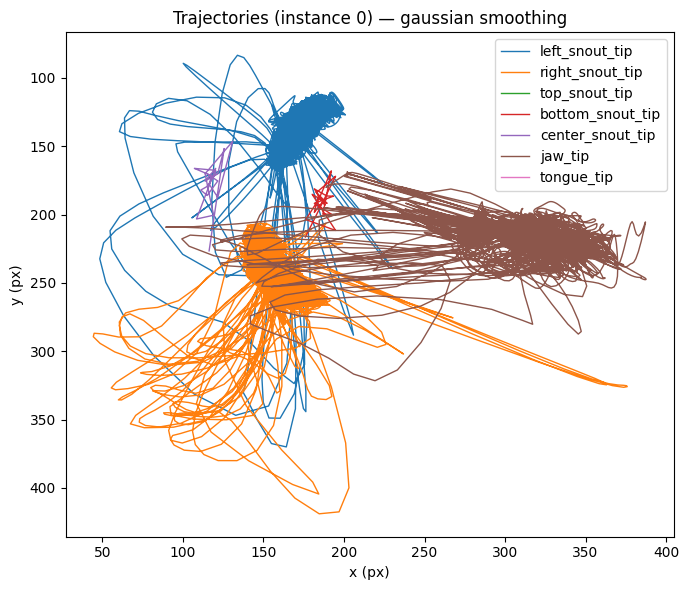

In [ ]:
INSTANCE = 0
SMOOTH_METHOD = "gaussian"
SIGMA = 2.0

to_plot = [n for n in TARGET_NODES if n in nodes]

plt.figure(figsize=(7,6))
for n in to_plot:
    xy = nodes[n][:, :, INSTANCE]  # (frames, 2)
    xy_s = smooth_xy(xy, method=SMOOTH_METHOD, sigma=SIGMA)
    plt.plot(xy_s[:,0], xy_s[:,1], label=n, linewidth=1)

plt.gca().invert_yaxis()
plt.title(f"Trajectories (instance {INSTANCE}) — {SMOOTH_METHOD} smoothing")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

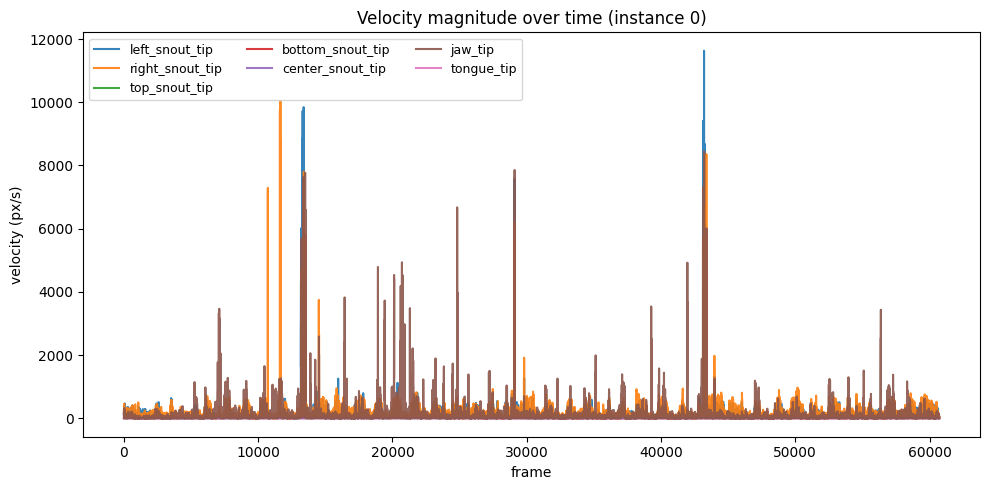

In [ ]:
plt.figure(figsize=(10,5))
for n in to_plot:
    xy = nodes[n][:, :, INSTANCE]
    xy_s = smooth_xy(xy, method=SMOOTH_METHOD, sigma=SIGMA)
    v = velocity(xy_s, dt=DT)
    plt.plot(v, label=n, alpha=0.9)

plt.title(f"Velocity magnitude over time (instance {INSTANCE})")
plt.xlabel("frame")
plt.ylabel("velocity (px/s)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

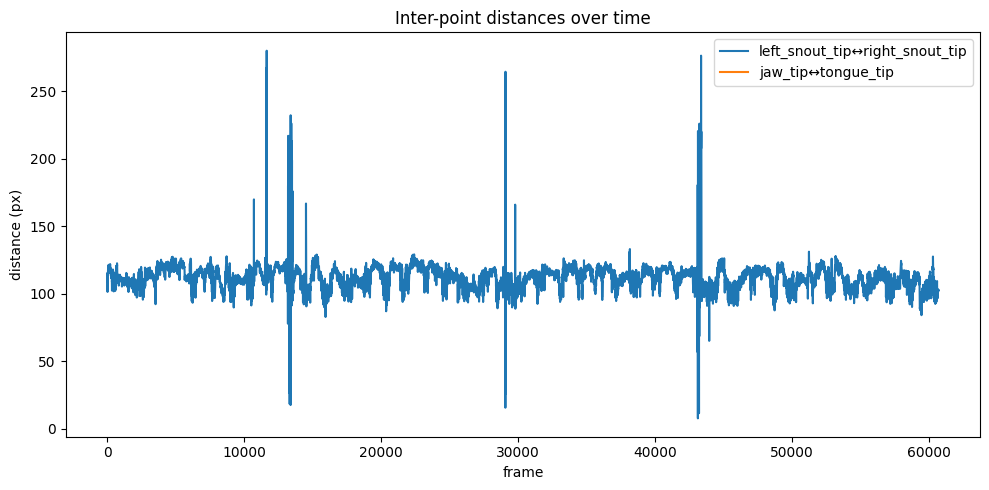

In [ ]:
def distance_between(node_a, node_b, instance=INSTANCE, method=SMOOTH_METHOD, sigma=SIGMA):
    xy_a = smooth_xy(nodes[node_a][:,:,instance], method=method, sigma=sigma)
    xy_b = smooth_xy(nodes[node_b][:,:,instance], method=method, sigma=sigma)
    d = np.linalg.norm(xy_a - xy_b, axis=1)
    return d

pairs = [
    ("left_snout_tip", "right_snout_tip"),
    ("jaw_tip", "tongue_tip"),
]

plt.figure(figsize=(10,5))
for a,b in pairs:
    if a in nodes and b in nodes:
        d = distance_between(a,b)
        plt.plot(d, label=f"{a}↔{b}")

plt.title("Inter-point distances over time")
plt.xlabel("frame")
plt.ylabel("distance (px)")
plt.legend()
plt.tight_layout()
plt.show()

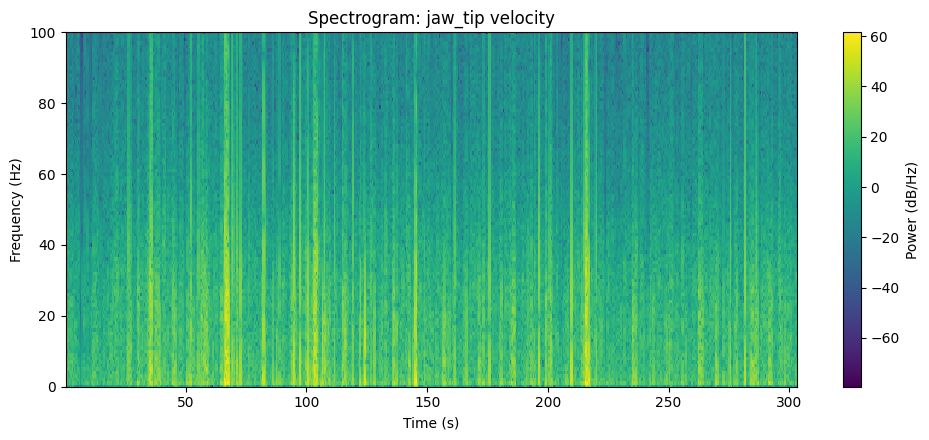

In [ ]:
def plot_spectrogram(
    signal_1d,
    fs,
    title="Spectrogram",
    nperseg=None,
    noverlap=None,
    detrend="constant",
    scaling="density",
    mode="psd",
    log_power=True,
):
    """
    Plot a spectrogram for a 1D time series.

    Parameters
    ----------
    signal_1d : array-like, shape (T,)
        The signal to analyze (e.g., velocity, distance, x-position).
    fs : float
        Sampling rate in Hz (e.g., FPS).
    nperseg : int, optional
        Window length (in samples). Defaults to ~1 second of data.
    noverlap : int, optional
        Overlap between windows. Defaults to 50% overlap.
    log_power : bool
        If True, plot 10*log10(PSD).
    """
    x = np.asarray(signal_1d, dtype=float)
    x = x - np.nanmean(x)
    x = np.nan_to_num(x, nan=0.0)

    if nperseg is None:
        nperseg = int(fs)
    nperseg = max(16, min(nperseg, len(x)))

    if noverlap is None:
        noverlap = nperseg // 2

    f, t, Sxx = spectrogram(
        x,
        fs=fs,
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=detrend,
        scaling=scaling,
        mode=mode,
    )

    Z = 10 * np.log10(Sxx + 1e-12) if log_power else Sxx

    plt.figure(figsize=(10, 4.5))
    plt.pcolormesh(t, f, Z, shading="auto")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.colorbar(label="Power (dB/Hz)" if log_power else "Power")
    plt.ylim(0, fs / 2)
    plt.tight_layout()
    plt.show()

node_name = "jaw_tip"
xy = nodes[node_name][:, :, INSTANCE]
xy_s = smooth_xy(xy, method=SMOOTH_METHOD, sigma=SIGMA)
v = velocity(xy_s, dt=DT)
plot_spectrogram(v, fs=FPS, title=f"Spectrogram: {node_name} velocity")